In [21]:
import cv2
import numpy as np
import torch
from torch import nn
from models import LinkNet34
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image, ImageFilter
import time
import sys
import os
import scipy.misc
import sklearn.metrics

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LinkNet34()
# model.load_state_dict(torch.load('linknet.pth'))
model.load_state_dict(torch.load('linknet.pth', map_location=lambda storage, loc: storage))
model.eval()
model.to(device)


LinkNet34(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

<h1>Helper functions 

In [111]:
def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """
    Return confusion matrix elements covering edge cases
    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns confusion matrix elements i.e TN, FP, FN, TP in that order and as floats
    returned as floats to make it feasible for float division for further calculations on them
    """
    _assert_valid_lists(groundtruth_list, predicted_list)

    if _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp



def _all_class_0_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [0] and np.unique(predicted_list).tolist() == [1]


def _all_class_1_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [1] and np.unique(predicted_list).tolist() == [0]

def _assert_valid_lists(groundtruth_list, predicted_list):
    assert len(groundtruth_list) == len(predicted_list)
    for unique_element in np.unique(groundtruth_list).tolist():
        assert unique_element in [0, 1]


def _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [1]


def _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [0]

def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """
    Returns a dictionary of 4 boolean numpy arrays containing True at TP, FP, FN, TN.
    """
    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs["tp"] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs["tn"] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs["fp"] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs["fn"] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs


def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, alpha, colors):
    """
    Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
    each a color given by the 'colors' dictionary
    
    """
    cv2.imwrite('color_img.jpg', image)
    image = cv2.imread('color_img.jpg', 1)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)

    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb

    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)


alpha = 0.7
confusion_matrix_colors = {
    "tp": (0, 255, 255),  # cyan
    "fp": (255, 0, 255),  # magenta
    "fn": (255, 255, 0),  # yellow
    "tn": (0, 0, 0)  # black
}

def _mcc_denominator_zero(tn, fp, fn, tp):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return (tn == 0 and fn == 0) or (tn == 0 and fp == 0) or (tp == 0 and fp == 0) or (tp == 0 and fn == 0)


def get_f1_score(groundtruth_list, predicted_list):
    """
    Return f1 score covering edge cases
    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns f1 score
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        f1_score = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        f1_score = 1
    else:
        f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score


def get_mcc(groundtruth_list, predicted_list):
    """
    Return mcc covering edge cases
    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns mcc
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        mcc = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        mcc = 1
    elif _all_class_1_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        mcc = -1
    elif _all_class_0_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        mcc = -1
    elif _mcc_denominator_zero(tn, fp, fn, tp) is True:
        mcc = -1
    else:
        mcc = ((tp * tn) - (fp * fn)) / (
            np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

    return mcc


def get_accuracy(groundtruth_list, predicted_list):
    """
    Return accuracy
    :param groundtruth_list list of elements
    :param predicted_list list of elements
    :return returns accuracy
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total

    return accuracy


def get_validation_metrics(groundtruth_list, predicted_list):
    """
    Return validation metrics dictionary with accuracy, f1 score, mcc after
    comparing ground truth and predicted image
    :param groundtruth_list list of elements
    :param predicted_list list of elements
    :return returns a dictionary with accuracy, f1 score, and mcc as keys
    one could add other stats like FPR, FNR, TP, TN, FP, FN etc
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    validation_metrics = {}

    validation_metrics["accuracy"] = get_accuracy(groundtruth_list, predicted_list)
    validation_metrics["f1_score"] = get_f1_score(groundtruth_list, predicted_list)
    validation_metrics["mcc"] = get_mcc(groundtruth_list, predicted_list)

    return validation_metrics

def get_IoU(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

<h1> Data preparation set 1

In [5]:
pth_lab = '/home/solar/proj/face-segmentation-master/datasel/labels'
pth_img = '/home/solar/proj/face-segmentation-master/datasel/images'

In [6]:
labelsDist = sorted(os.listdir(pth_lab))

In [7]:
labels = []
for item in labelsDist:
    img = Image.open(os.path.join(pth_lab,item))
    #plt.imshow(img)
    data = np.asarray(img)
    data_c = data.copy()
    for i in range(len(data)):
        for j in range(len(data[1])):
            if data[i][j]==2:
                data_c[i][j]=0
    labels.append(data_c)

1

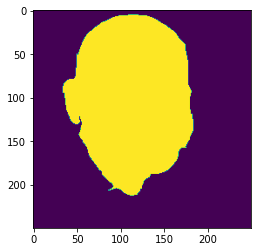

In [8]:
plt.imshow(labels[2])
labels[2].shape
labels[2][100,100]

In [9]:
imagesDist = sorted(os.listdir(pth_img))

In [10]:
images_list = []
for item in imagesDist:
    img = Image.open(os.path.join(pth_img,item))
    #plt.imshow(img)
    data = np.asarray(img)
    images_list.append(data)

In [11]:
images_list[0].shape

(250, 250, 3)

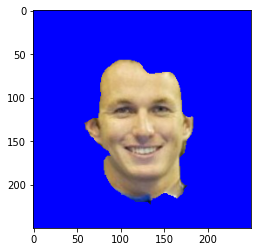

In [12]:
result = images_list[0].copy()
result[labels[0]==0] = (0,0,255)
plt.imshow(result)

In [13]:
img_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
mask_list = []
for item in imagesDist:
    img = Image.open(os.path.join(pth_img,item))
    #width, height = im.size
    #print(width, height)
    a = img_transform(img)
    a = a.unsqueeze(0)
    imgs = Variable(a.to(dtype=torch.float, device=device))
    predic = model(imgs)
            
    pred= torch.nn.functional.interpolate(predic, size=[250, 250])
    mask = pred.data.cpu().numpy()
    #print(mask.shape)
    mask = mask.squeeze()
    mask = mask > 0.8
    mask_list.append(mask.astype(int))

(250, 250)

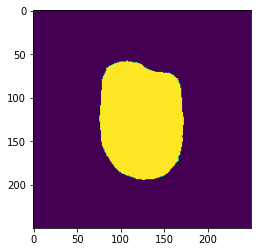

In [14]:
plt.imshow(mask_list[0])
mask_list[1].shape
labels = []
for item in labelsDist:
    img = Image.open(os.path.join(pth_lab,item))
    #plt.imshow(img)
    data = np.asarray(img)
    data_c = data.copy()
    for i in range(len(data)):
        for j in range(len(data[1])):
            if data[i][j]==2:
                data_c[i][j]=0
    labels.append(data_c)

<h1> Validation set 1
    

Validation Metrics 
{'accuracy': 0.94648, 'f1_score': 0.866033882013697, 'mcc': 0.8434604575504111}
IoU  0.763721127357491


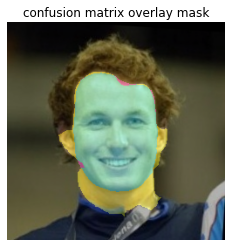

Validation Metrics 
{'accuracy': 0.960144, 'f1_score': 0.8876764215177887, 'mcc': 0.8704620808563482}
IoU  0.7980379438949246


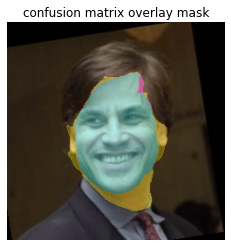

Validation Metrics 
{'accuracy': 0.948592, 'f1_score': 0.9241196892048272, 'mcc': 0.8884562739254563}
IoU  0.8589428395820529


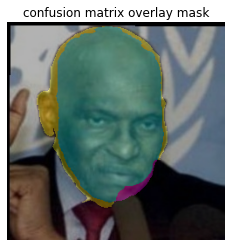

Validation Metrics 
{'accuracy': 0.868816, 'f1_score': 0.6637687102727087, 'mcc': 0.5851153129351232}
IoU  0.4967468696292659


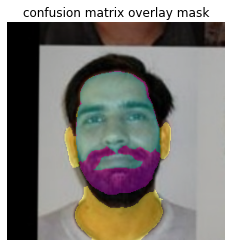

In [82]:
conf_mat_all = np.array([0,0,0,0])
for i in range(len(labels)):
    groundtruth_list = (labels[i]).flatten().tolist()
    predicted_list = (mask_list[i]).flatten().tolist()
    conf_mat = get_confusion_matrix_elements(groundtruth_list,predicted_list)
    conf_mat_all=np.add(conf_mat_all,np.array(conf_mat))
    validation_mask = get_confusion_matrix_overlaid_mask(images_list[i], labels[i], mask_list[i], alpha,
                                                     confusion_matrix_colors)
    validation_metrics = get_validation_metrics(groundtruth_list, predicted_list)
    print("Validation Metrics ")
    print(validation_metrics)
    print('IoU ',get_IoU(labels[i],mask_list[i]))
    plt.imshow(validation_mask)
    plt.axis('off')
    plt.title("confusion matrix overlay mask")
    plt.show()

In [83]:
groundtruth_list = (labels[0]).flatten().tolist()
predicted_list = (mask_list[0]).flatten().tolist()
#conf_mat = confusion_matrix(y_true=labels[0], y_pred=mask_list[0])
conf_mat = get_confusion_matrix_elements(groundtruth_list,predicted_list)

In [84]:
validation_mask = get_confusion_matrix_overlaid_mask(images_list[0], labels[0], mask_list[0], alpha,
                                                     confusion_matrix_colors)

In [85]:
print("Cyan - TP")
print("Magenta - FP")
print("Yellow - FN")
print("Black - TN")



Cyan - TP
Magenta - FP
Yellow - FN
Black - TN


<h1> Data preparation set 2

In [130]:
pth_lab = '/home/solar/proj/face-segmentation-master/datasel/labold'
pth_img = '/home/solar/proj/face-segmentation-master/datasel/imold'
labelsDist = sorted(os.listdir(pth_lab))
imagesDist = sorted(os.listdir(pth_img))
images_list = []
for item in imagesDist:
    img = Image.open(os.path.join(pth_img,item))
    img = img.resize((250,250))
    data = np.asarray(img)
    images_list.append(data)
img_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
mask_list = []
for item in imagesDist:
    img = Image.open(os.path.join(pth_img,item))
    #width, height = im.size
    #print(width, height)
    a = img_transform(img)
    a = a.unsqueeze(0)
    imgs = Variable(a.to(dtype=torch.float, device=device))
    predic = model(imgs)
            
    pred= torch.nn.functional.interpolate(predic, size=[250, 250])
    mask = pred.data.cpu().numpy()
    #print(mask.shape)
    mask = mask.squeeze()
    mask = mask > 0.8
    mask_list.append(mask.astype(int))
labels = []
for item in labelsDist:
    img = Image.open(os.path.join(pth_lab,item))
    img = img.resize((250,250))
    #img =  img > 0
    data = np.asarray(img)
    data =  data > 0
    data = data.astype(int)
    data_c = data.copy()
    for i in range(len(data)):
        for j in range(len(data[1])):
            if data[i][j]==2:
                data_c[i][j]=0
    labels.append(data_c)

<h1> Validation set 2

Validation Metrics 
{'accuracy': 0.97272, 'f1_score': 0.9045299288873957, 'mcc': 0.8940141236807705}
IoU  0.8257002657943161


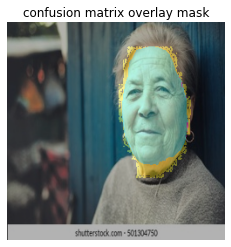

Validation Metrics 
{'accuracy': 0.963152, 'f1_score': 0.9401087041323174, 'mcc': 0.916060223243164}
IoU  0.8869859652566493


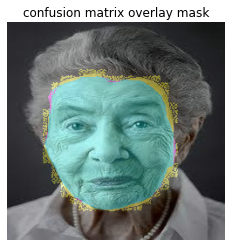

Validation Metrics 
{'accuracy': 0.95192, 'f1_score': 0.932470392593092, 'mcc': 0.900096719093666}
IoU  0.873484338160997


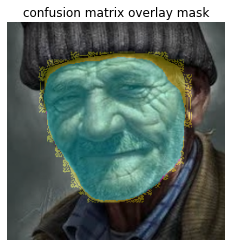

In [131]:
conf_mat_all = np.array([0,0,0,0])
for i in range(len(labels)):
    groundtruth_list = (labels[i]).flatten().tolist()
    predicted_list = (mask_list[i]).flatten().tolist()
    conf_mat = get_confusion_matrix_elements(groundtruth_list,predicted_list)
    conf_mat_all=np.add(conf_mat_all,np.array(conf_mat))
    validation_mask = get_confusion_matrix_overlaid_mask(images_list[i], labels[i], mask_list[i], alpha,
                                                     confusion_matrix_colors)
    validation_metrics = get_validation_metrics(groundtruth_list, predicted_list)
    print("Validation Metrics ")
    print(validation_metrics)
    print('IoU ',get_IoU(labels[i],mask_list[i]))
    plt.imshow(validation_mask)
    plt.axis('off')
    plt.title("confusion matrix overlay mask")
    plt.show()

TESTY !!!!

In [132]:
img_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
with Image.open("img5.jpeg").resize(((250,250))) as im:
    #im.show()
    
    a = img_transform(im)
    a = a.unsqueeze(0)
imgs = Variable(a.to(dtype=torch.float, device=device))
srcim = cv2.imread("img5.jpeg")
srcim = cv2.resize(srcim,(250,250))

In [133]:
predic = model(imgs)
            
pred= torch.nn.functional.interpolate(predic, size=[250, 250])
mask = pred.data.cpu().numpy()
print(mask.shape)
mask = mask.squeeze()
mask = mask > 0.8

#cv2.imwrite('color_img.jpg', np.array(imgs)
#c = cv2.imread('color_img.jpg', 1)

rgba = cv2.cvtColor(srcim, cv2.COLOR_BGR2BGRA)
ind = np.where(mask == 0)
rgba[ind] = rgba[ind] - [0,0,0, 180]
            
canvas = Image.new('RGBA', (rgba.shape[1], rgba.shape[0]), (255,255,255,255))
canvas.paste(Image.fromarray(rgba), mask=Image.fromarray(rgba))
rgba = np.array(canvas)
rgb = cv2.cvtColor(rgba, cv2.COLOR_BGRA2BGR)

(1, 1, 250, 250)


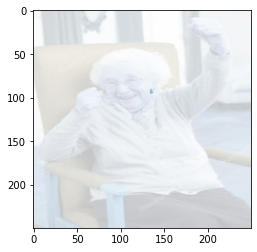

In [134]:
#cv2.imshow('mask', rgb)
plt.imshow(rgba)

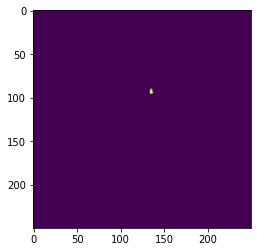

In [135]:
plt.imshow(mask)